<font size = 32> Juvo test </font>

# Import libraries

In [1]:
############################################### Run this at first time###############################################
# !pip install imbalanced-learn==0.9.0
# !pip install scikit-learn==1.0.2
# !pip install numpy==1.19.5
# !pip install xgboost==1.6.1
# !pip install pandas==1.3.2
# !pip install matplotlib==3.3.3
# !pip install seaborn==0.11.1

In [132]:
#Data manipulation libs
import pandas as pd
import numpy as np

#Machine Learning libs
import sklearn
## Missing data inputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
##One Hot encoding
from sklearn.preprocessing import OneHotEncoder
##Model selection
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
##Metrics
from sklearn.metrics import confusion_matrix, balanced_accuracy_score,precision_score,recall_score,roc_auc_score,f1_score
##Models to test
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
##Oversampling
import imblearn
from imblearn.over_sampling import SMOTE

#Plot
import matplotlib.pyplot as plt
import seaborn as sns

#Aux libs
from functools import reduce

pd.options.display.max_columns = None

%reload_ext watermark
%watermark --iversions

pandas    : 1.3.2
xgboost   : 1.6.1
seaborn   : 0.11.1
sklearn   : 1.0.2
imblearn  : 0.9.0
matplotlib: 3.3.3
numpy     : 1.19.5



# Functions

In [3]:
def variable_summary(series: pd.Series):
    """
    Series describer
    
    Parameters
    ----------
    :series: pandas Series to analyse 
    """
    variable = series.name
    dtype = series.dtype
    na = series.isna().sum()
    na_pct = str(round(100*na/series.shape[0],2))+"%"
    if('object' in str(dtype)):
        first_element = series.pipe(lambda x: x[x==x])
        if(first_element.shape[0] == 0):
            unique = series.nunique()
        else:
            element_type = str(type(first_element.iloc[0]))
            if((element_type == "<class 'numpy.ndarray'>") | (element_type == "<class 'list'>") | (element_type == "<class 'set'>") | (element_type == "<class 'dict'>")):
                unique = '-'
            else:
                unique = series.nunique()
    else:
        unique = series.nunique()
    
    
    if( ('object' in str(dtype)) | ('category' in str(dtype)) ):
        minimum,mean,maximum,std,quat25,quat75,median,skew,kurt,mean_std = ("-","-","-","-","-","-","-","-","-","-")
    else:
        minimum = series.min()
        mean = series.mean()
        maximum = series.max()
        std = series.std()
        if('bool' in str(dtype)):
            quat25 = series.astype(float).quantile(0.25)
            quat75 = series.astype(float).quantile(0.75)
            median = series.astype(float).quantile(0.5)
        else:
            quat25 = series.quantile(0.25)
            quat75 = series.quantile(0.75)
            median = series.quantile(0.5)
        
        if( ('int' in str(dtype)) | ('float' in str(dtype)) ):
            skew = round(series.skew(),2) #skewness
            kurt = round(series.kurt(),2) #kurtosis
            if((all(series == 0)) or (std == 0)):
                mean_std = 0
            else:
                mean_std = round(mean/std,2)
        else:
            skew,kurt,mean_std = ("-","-","-")
        
        
    return(pd.DataFrame({'variable':[variable],
                        'type':[dtype],
                        'na':[na],
                        'na_pct':[na_pct],
                        'unique':[unique],
                        'min':[minimum],
                        'quat25':[quat25],
                        'median':[median],
                        'mean':[mean],
                        'quat75':[quat75],
                        'max':[maximum],
                        'std':[std],
                        'skewness':[skew],
                        'kurtosis':[kurt],
                        'media_desvio':[mean_std]}))

#Data describer function
def describe(df):
    """
    Dataframe describer
    
    Parameters
    ----------
    :df: pandas DataFrame to analyse 
    """
    print("Number of Rows:",df.shape[0])
    describe_dataset = reduce(lambda x,y: pd.concat((x,y)), [variable_summary(df[col]) for col in df.columns])
    return describe_dataset.reset_index(drop=True)


# Import data

In [4]:
loans = pd.read_csv("../data/Brazil_DS_loans_2019-11-10_2019-12-05.csv")
prev  = pd.read_csv("../data/Brazil_DS_prev_loans.csv")
recharge = pd.read_csv("../data/Brazil_DS_recharges_2019-08-10_2019-12-05.csv")

In [5]:
#Convert into datetime
prev.created_at = pd.to_datetime(prev.created_at)
loans.created_at = pd.to_datetime(loans.created_at)
recharge.recharge_timestamp = pd.to_datetime(recharge.recharge_timestamp)

In [6]:
#Loans description
#There are only 2 different loan amount
#On this one, only 18.89%% did not paided
describe(loans)

Number of Rows: 12926


,variable,type,na,na_pct,unique,min,quat25,median,mean,quat75,max,std,skewness,kurtosis,media_desvio
0,uuid,object,0,0.0%,9513,-,-,-,-,-,-,-,-,-,-
1,loan_id,int64,0,0.0%,12926,16513,19745.25,22986.5,22984.485842,26218.75,29454,3736.246948,-0.0,-1.2,6.15
2,amount,float64,0,0.0%,2,5.0,5.0,5.0,5.449095,5.0,10.0,1.429666,2.87,6.24,3.81
3,created_at,datetime64[ns],0,0.0%,12926,2019-11-10 00:04:42.327443,2019-11-18 00:32:10.321530624,2019-11-24 13:47:35.415590400,2019-11-23 19:56:40.806889472,2019-11-29 15:08:45.370689024,2019-12-04 23:54:57.280521,6 days 22:38:10.394918360,-,-,-
4,paid_at,object,2442,18.89%,10484,-,-,-,-,-,-,-,-,-,-


In [7]:
#Prev description
#There are only 4 different loan amount
#On this one, only 0.58% did not paided
#less users than loans dataset
describe(prev)

Number of Rows: 6035


,variable,type,na,na_pct,unique,min,quat25,median,mean,quat75,max,std,skewness,kurtosis,media_desvio
0,uuid,object,0,0.0%,1964,-,-,-,-,-,-,-,-,-,-
1,loan_id,int64,0,0.0%,6035,1,6669.0,10455.0,9932.314499,13641.5,16504,4315.519482,-0.37,-0.89,2.3
2,amount,float64,0,0.0%,4,3.85,5.0,5.0,5.77029,5.0,10.0,1.805531,1.92,1.67,3.2
3,created_at,datetime64[ns],0,0.0%,6035,2019-01-16 23:41:24.785649,2019-09-20 13:26:54.973658112,2019-10-12 09:15:09.591973888,2019-10-04 06:41:34.816445696,2019-10-28 16:23:30.478653440,2019-11-09 23:07:27.962833,32 days 11:29:48.450471939,-,-,-
4,paid_at,object,35,0.58%,6000,-,-,-,-,-,-,-,-,-,-


In [8]:
#recharge description
describe(recharge)

Number of Rows: 94793


,variable,type,na,na_pct,unique,min,quat25,median,mean,quat75,max,std,skewness,kurtosis,media_desvio
0,uuid,object,0,0.0%,9431,-,-,-,-,-,-,-,-,-,-
1,recharge_timestamp,datetime64[ns],0,0.0%,94058,2019-08-10 00:04:21,2019-09-19 21:42:41,2019-10-23 11:31:45,2019-10-17 19:35:46.300845312,2019-11-16 15:59:02,2019-12-04 23:53:01,33 days 22:34:54.137257993,-,-,-
2,recharge_value,float64,0,0.0%,15,3.0,5.0,10.0,11.328081,15.0,100.0,6.757032,1.7,6.07,1.68
3,balance_after_recharge,float64,52,0.05%,3175,0.0,6.07,10.27,12.432254,15.65,264.44,7.862897,4.54,83.96,1.58
4,institution_name,object,35412,37.36%,114,-,-,-,-,-,-,-,-,-,-
5,institution_type,object,35804,37.77%,9,-,-,-,-,-,-,-,-,-,-


# Data analysis

According to the explanation: "_A loan is considered repaid if it's paid within 60 days_".<br> 
Besides, "_a user pays for loans by making recharges after taking a loan_"<br>
Let's see this behaviour taking a user

In [9]:
prev.query("paid_at != paid_at").head(10)

,uuid,loan_id,amount,created_at,paid_at
116,fa19674e1eb344f8b19591c493a4557b,1371,5.0,2019-07-12 09:37:46.031214,NaN
483,a66c6e2d6b6540c6b2f6a136def16cd1,1269,5.0,2019-07-10 02:15:15.857633,NaN
574,1e449a1ac95a49c3b8353dd05749d78d,2426,5.0,2019-08-02 23:39:21.905010,NaN
621,1dd011320a994ef7a4453f5745d7ce4f,1487,5.0,2019-07-14 22:01:48.230560,NaN
912,67b98f4c0c66470198a2f7bd179b3b97,648,5.0,2019-06-25 13:55:48.236896,NaN
1155,4f73292fb7864e41a9853967789e64b3,936,5.0,2019-07-02 12:42:29.478425,NaN
1182,d72c0910dba4436fa420df0a59adeb1a,2688,5.0,2019-08-07 21:22:52.958146,NaN
1559,56c089f373fc4f7bb46c5e56f11edaa1,382,5.0,2019-06-15 01:18:59.349732,NaN
1605,95f77a808cf240339a4c7bfbe903970d,622,5.0,2019-06-24 18:58:18.449026,NaN
1809,9f58366573394e4587675d5cd7188adc,726,5.0,2019-06-27 12:41:36.313722,NaN


In this following example, even after the user recharging the loan 1371, the time between the loan and the first recharge is over 60 days, so the loan is considered not paid. However, considering the loan 23811, the payment occured a few days after that

In [10]:
uuid = 'fa19674e1eb344f8b19591c493a4557b'
pd.concat((prev.query("'%s' == uuid"%uuid).assign(DF='prev'),
           loans.query("'%s' == uuid"%uuid).assign(DF = 'loans'))).sort_values('created_at')

,uuid,loan_id,amount,created_at,paid_at,DF
116,fa19674e1eb344f8b19591c493a4557b,1371,5.0,2019-07-12 09:37:46.031214,NaN,prev
5221,fa19674e1eb344f8b19591c493a4557b,23811,5.0,2019-11-26 04:09:43.098861,2019-11-30 01:04:05.827473,loans


In [11]:
recharge.query("'%s' == uuid"%uuid).sort_values("recharge_timestamp")

,uuid,recharge_timestamp,recharge_value,balance_after_recharge,institution_name,institution_type
38027,fa19674e1eb344f8b19591c493a4557b,2019-10-14 23:23:29,10.0,10.09,M4U URA-USSD,Distribuidor Nacional
80222,fa19674e1eb344f8b19591c493a4557b,2019-11-26 01:09:43,5.0,5.10,NaN,NaN
83980,fa19674e1eb344f8b19591c493a4557b,2019-11-29 22:03:29,13.0,14.12,M4U URA-USSD,Distribuidor Nacional


Are the institution name and type always the same, taking the same uuid?

In [12]:
#No
def nunique(x):
    return x.nunique()
recharge[['institution_name','institution_type','uuid']].drop_duplicates().groupby("uuid").agg({"institution_name":nunique,"institution_type":nunique})

,institution_name,institution_type
uuid,,
000c20ae97084d4199e1c61a6a15a79e,0,0
000c4c43634a4e4cabee82c946481adc,4,2
00163f5a2e75448daf00186d60ce5ce7,2,2
00186a872c254b5fbd8be83f5343efec,1,1
001d161dd9854887b7d38e5f40db36c9,4,2
...,...,...
ffd5de5cc31e4627bad4db3bb86729e0,3,3
ffd62186c39c45d785b5fe15e0a79b11,5,3
ffd8a8416e824e4289e4f5d4cc69f8de,5,2


Is the balance after recharge always bigger or equal than the recharge itself?

In [13]:
#No
((recharge['balance_after_recharge']-recharge['recharge_value']) <0).sum()

17

In [14]:
recharge.assign(test = lambda x: x['balance_after_recharge'] - x['recharge_value']).query('test < 0')

,uuid,recharge_timestamp,recharge_value,balance_after_recharge,institution_name,institution_type,test
5530,d1785a6bfa5e446995425a9338009bad,2019-08-22 09:42:53,49.99,0.00,M4U Venda Direta 3,Venda Direta,-49.99
12251,aab4e319955744cd8367adb945733c77,2019-08-27 09:59:24,49.99,0.04,M4U Venda Direta 3,Venda Direta,-49.95
15293,82b377f9615049fc9cf6bd08a32016a5,2019-09-09 09:50:14,49.99,0.00,M4U Venda Direta 3,Venda Direta,-49.99
15494,302496aab95040feba336208d483db5e,2019-09-09 09:50:37,49.99,0.00,M4U Venda Direta 3,Venda Direta,-49.99
15994,34d45fa905754e7eb51abf375858b7ed,2019-09-08 09:30:30,31.49,0.30,M4U Venda Direta,Venda Direta,-31.19
22504,d1785a6bfa5e446995425a9338009bad,2019-09-22 09:33:46,49.99,0.00,M4U Venda Direta 3,Venda Direta,-49.99
28207,aab4e319955744cd8367adb945733c77,2019-09-27 10:19:54,49.99,0.04,M4U Venda Direta 3,Venda Direta,-49.95
34954,34d45fa905754e7eb51abf375858b7ed,2019-10-08 09:25:57,31.49,13.91,M4U Venda Direta,Venda Direta,-17.58
37873,302496aab95040feba336208d483db5e,2019-10-09 11:37:50,49.99,0.00,M4U Venda Direta 3,Venda Direta,-49.99
39743,f43f85b04cdb4ced9c10f94b0ca2f763,2019-10-16 18:57:57,49.89,0.00,M4U Venda Direta 3,Venda Direta,-49.89


Let's take an example

In [15]:
loan_ = pd.concat((prev,loans))

In [16]:
loan_.query("uuid == '302496aab95040feba336208d483db5e'")

,uuid,loan_id,amount,created_at,paid_at
11710,302496aab95040feba336208d483db5e,22496,5.0,2019-11-23 10:31:28.434921,2019-12-07 19:51:53.315303


Let's create a single dataset, with the data history

In [17]:
df = pd.concat((loan_,recharge.rename(columns = {"recharge_timestamp":"created_at","recharge_value":"amount"})))\
    .sort_values(["uuid","created_at"]).reset_index(drop=True)

In [18]:
#If loan_id is NULL, than it is a recharge. Otherwise, it is a loan
df.query("'7faa3668919145fdbb703ab80bdd60ff' == uuid")

,uuid,loan_id,amount,created_at,paid_at,balance_after_recharge,institution_name,institution_type
55494,7faa3668919145fdbb703ab80bdd60ff,NaN,5.0,2019-11-12 12:38:31.000000,NaN,5.01,NaN,NaN
55495,7faa3668919145fdbb703ab80bdd60ff,17169.0,5.0,2019-11-12 15:38:30.448831,NaN,NaN,NaN,NaN


In [19]:
describe(df)

Number of Rows: 113754


,variable,type,na,na_pct,unique,min,quat25,median,mean,quat75,max,std,skewness,kurtosis,media_desvio
0,uuid,object,0,0.0%,9513,-,-,-,-,-,-,-,-,-,-
1,loan_id,float64,94793,83.33%,18961,1.0,14068.0,19959.0,18830.176784,24710.0,29454.0,7239.446855,-0.59,-0.52,2.6
2,amount,float64,0,0.0%,17,3.0,5.0,10.0,10.365187,15.0,100.0,6.56439,1.86,6.58,1.58
3,created_at,datetime64[ns],0,0.0%,113019,2019-01-16 23:41:24.785649,2019-09-24 14:57:04,2019-10-29 17:25:13.500000,2019-10-21 07:18:11.359803392,2019-11-20 06:00:47.915520,2019-12-04 23:54:57.280521,34 days 06:33:11.679607582,-,-,-
4,paid_at,object,97270,85.51%,16484,-,-,-,-,-,-,-,-,-,-
5,balance_after_recharge,float64,19013,16.71%,3175,0.0,6.07,10.27,12.432254,15.65,264.44,7.862897,4.54,83.96,1.58
6,institution_name,object,54373,47.8%,114,-,-,-,-,-,-,-,-,-,-
7,institution_type,object,54765,48.14%,9,-,-,-,-,-,-,-,-,-,-


Some feature we should create:
* loan amount until now
* recharge amount until now
* recharge count until now
* loan count until now
* not paid loan amount until now
* days since the last not paid loan
* days since the last recharge
* days since the last loan
* last instituition type
* most commum instituition type
* balance_after_recharge - recharge mean since the last loan

# ABT

In [20]:
df=df.assign(current_loan = lambda x: x.groupby("uuid").loan_id.transform(lambda y: y.fillna(method='ffill')),
             description = lambda x: np.where(x["loan_id"] == x["loan_id"],'loan','recharge'))

Creating the new features

In [21]:
#loan amount until now
df["loan_amount_cumsum"] = df.assign(loan_amount = lambda x: np.where(x["description"] == 'loan',x['amount'],0))\
                             .groupby('uuid').loan_amount.transform(lambda x: x.cumsum())

#recharge amount until now
df["recharge_amount_cumsum"] = df.assign(recharge_amount = lambda x: np.where(x["description"] == 'recharge',x['amount'],0))\
                             .groupby('uuid').recharge_amount.transform(lambda x: x.cumsum())

#loan count until now
df["loan_cumcount"] = df.assign(loan_times = lambda x: np.where(x["description"] == 'loan',1,0))\
                             .groupby('uuid').loan_times.transform(lambda x: x.cumsum())
#recharge count until now
df["recharge_cumcount"] = df.assign(recharge_times = lambda x: np.where(x["description"] == 'recharge',1,0))\
                             .groupby('uuid').recharge_times.transform(lambda x: x.cumsum())

#not paid loan amount until now
df = df.merge(df.query("description == 'loan'")\
      .assign(not_paid_amount = lambda y: np.where(y["paid_at"] != y["paid_at"],
                                                                    y["amount"],
                                                                    0))\
      .assign(not_paid_loan_cumsum = lambda y: y.groupby("uuid").not_paid_amount.transform(lambda x: x.shift(1).cumsum()))\
      [['uuid','loan_id','not_paid_loan_cumsum']],
            on = ["uuid","loan_id"],
            how = 'left')

#target feature for classification
df["target"] = np.where(df["paid_at"] == df["paid_at"],0,1)

#days since the last not paid loan
df = df.merge(df.query("description == 'loan'")\
    .assign(last_loan_not_paid = lambda x: np.where(x["paid_at"] != x["paid_at"],
                                                    x["created_at"],
                                                    np.datetime64("NaT"))
           )\
    .assign(last_loan_not_paid = lambda x: x.groupby("uuid")["last_loan_not_paid"].transform(lambda y: y.shift(1).fillna(method="ffill")))\
    .assign(days_after_last_no_paid = lambda x: (x["created_at"] - x["last_loan_not_paid"])/np.timedelta64(1,"D"))\
         [["uuid","loan_id","days_after_last_no_paid"]],
        how = 'left',
        on = ["uuid","loan_id"])

#days since the last recharge
df["days_after_last_recharge"] = (df["created_at"] - df.join(df.groupby("uuid")\
          .apply(lambda y: np.where(y["description"] == 'recharge',
                                    y["created_at"],
                                    np.datetime64("NaT"))).explode().reset_index().rename(columns={0:"last_recharge"}).drop(columns="uuid"))\
          .groupby("uuid").last_recharge.transform(lambda x: x.fillna(method = 'ffill')))/np.timedelta64(1,"D")

#days since the last loan
df = df.merge(df.query("description == 'loan'")\
  .pipe(lambda x: x.join(x.groupby("uuid").created_at.transform(lambda x: x.shift(1)).rename("last_loan")))\
  .assign(days_after_last_loan = lambda x: (x["created_at"] - x["last_loan"])/np.timedelta64(1,"D"))\
  [["uuid","loan_id","days_after_last_loan"]],
        how ='left',
        on = ["uuid","loan_id"])

#most commum instituition type
df = df.merge(df.groupby(["uuid",'institution_type']).amount.count().sort_values(ascending=False).reset_index()\
           .rename(columns = {"institution_type":"most_commum_institution_type"})\
           .groupby("uuid").most_commum_institution_type.first().reset_index(),
        on = 'uuid',
         how = 'left')

#last instituition type
df["last_intitution_type"] = df.groupby("uuid").institution_type.transform(lambda x: x.fillna(method="ffill"))

#balance_after_recharge - recharge mean since the last loan
df = df.merge(df.assign(loan_id_aux = lambda x: x.groupby("uuid").loan_id.transform(lambda y:y.fillna(method="bfill")))\
  .assign(loan_id_aux = lambda x: np.where(x["loan_id"] == x["loan_id_aux"],np.nan,x["loan_id_aux"]))\
  .groupby(["uuid","loan_id_aux"]).apply(lambda x: (x["balance_after_recharge"]-x["amount"]).mean()).reset_index()\
  .rename(columns = {"loan_id_aux":"loan_id",0:"diff_balance_recharge"}),
        on = ["uuid","loan_id"],
        how = "left")

In [22]:
#Test case
df.query("uuid == 'e6504b30a1c844eeb3bd3fd9a2d4c2a3'")

,uuid,loan_id,amount,created_at,paid_at,balance_after_recharge,institution_name,institution_type,current_loan,description,loan_amount_cumsum,recharge_amount_cumsum,loan_cumcount,recharge_cumcount,not_paid_loan_cumsum,target,days_after_last_no_paid,days_after_last_recharge,days_after_last_loan,most_commum_institution_type,last_intitution_type,diff_balance_recharge
101224,e6504b30a1c844eeb3bd3fd9a2d4c2a3,1.0,3.85,2019-01-16 23:41:24.785649,NaN,NaN,NaN,NaN,1.0,loan,3.85,0.0,1,0,NaN,1,NaN,NaN,NaN,Distribuidor Nacional,NaN,NaN
101225,e6504b30a1c844eeb3bd3fd9a2d4c2a3,2.0,4.85,2019-01-16 23:41:59.417087,NaN,NaN,NaN,NaN,2.0,loan,8.70,0.0,2,0,3.85,1,0.000401,NaN,0.000401,Distribuidor Nacional,NaN,NaN
101226,e6504b30a1c844eeb3bd3fd9a2d4c2a3,3.0,5.00,2019-01-16 23:43:16.427969,NaN,NaN,NaN,NaN,3.0,loan,13.70,0.0,3,0,8.70,1,0.000891,NaN,0.000891,Distribuidor Nacional,NaN,NaN
101227,e6504b30a1c844eeb3bd3fd9a2d4c2a3,104.0,5.00,2019-04-30 14:08:32.977881,2019-05-29 14:39:54.016985,NaN,NaN,NaN,104.0,loan,18.70,0.0,4,0,13.70,0,103.600886,NaN,103.600886,Distribuidor Nacional,NaN,NaN
101228,e6504b30a1c844eeb3bd3fd9a2d4c2a3,2305.0,5.00,2019-07-31 15:20:09.776068,2019-08-30 22:33:59.344821,NaN,NaN,NaN,2305.0,loan,23.70,0.0,5,0,13.70,0,195.650617,NaN,92.049731,Distribuidor Nacional,NaN,NaN
101229,e6504b30a1c844eeb3bd3fd9a2d4c2a3,NaN,15.00,2019-08-30 19:32:37.000000,NaN,15.16,Itau,Banco,2305.0,recharge,23.70,15.0,5,1,NaN,1,NaN,0.000000,NaN,Distribuidor Nacional,Banco,NaN
101230,e6504b30a1c844eeb3bd3fd9a2d4c2a3,NaN,5.00,2019-09-26 14:31:24.000000,NaN,5.19,NaN,NaN,2305.0,recharge,23.70,20.0,5,2,NaN,1,NaN,0.000000,NaN,Distribuidor Nacional,Banco,NaN
101231,e6504b30a1c844eeb3bd3fd9a2d4c2a3,7659.0,5.00,2019-09-26 17:31:22.789939,2019-10-10 18:07:25.654335,NaN,NaN,NaN,7659.0,loan,28.70,20.0,6,2,13.70,0,252.741740,0.124986,57.091123,Distribuidor Nacional,Banco,0.175000
101232,e6504b30a1c844eeb3bd3fd9a2d4c2a3,NaN,13.00,2019-10-10 15:06:51.000000,NaN,13.21,Recarga Pay,Distribuidor Nacional,7659.0,recharge,28.70,33.0,6,3,NaN,1,NaN,0.000000,NaN,Distribuidor Nacional,Distribuidor Nacional,NaN
101233,e6504b30a1c844eeb3bd3fd9a2d4c2a3,NaN,10.00,2019-11-06 17:13:02.000000,NaN,10.23,Recarga Pay,Distribuidor Nacional,7659.0,recharge,28.70,43.0,6,4,NaN,1,NaN,0.000000,NaN,Distribuidor Nacional,Distribuidor Nacional,NaN


Removing recharges

In [23]:
df_ = df.query("description == 'loan'").drop(columns = 'description')

In [24]:
describe(df_)

Number of Rows: 18961


,variable,type,na,na_pct,unique,min,quat25,median,mean,quat75,max,std,skewness,kurtosis,media_desvio
0,uuid,object,0,0.0%,9513,-,-,-,-,-,-,-,-,-,-
1,loan_id,float64,0,0.0%,18961,1.0,14068.0,19959.0,18830.176784,24710.0,29454.0,7239.446855,-0.59,-0.52,2.6
2,amount,float64,0,0.0%,4,3.85,5.0,5.0,5.551326,5.0,10.0,1.566274,2.49,4.19,3.54
3,created_at,datetime64[ns],0,0.0%,18961,2019-01-16 23:41:24.785649,2019-10-30 12:19:01.683214080,2019-11-18 15:29:41.445861120,2019-11-07 17:47:05.939935232,2019-11-27 19:16:52.188889088,2019-12-04 23:54:57.280521,30 days 09:11:00.366475161,-,-,-
4,paid_at,object,2477,13.06%,16484,-,-,-,-,-,-,-,-,-,-
5,balance_after_recharge,float64,18961,100.0%,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,institution_name,object,18961,100.0%,0,-,-,-,-,-,-,-,-,-,-
7,institution_type,object,18961,100.0%,0,-,-,-,-,-,-,-,-,-,-
8,current_loan,float64,0,0.0%,18961,1.0,14068.0,19959.0,18830.176784,24710.0,29454.0,7239.446855,-0.59,-0.52,2.6
9,loan_amount_cumsum,float64,0,0.0%,62,3.85,5.0,5.0,15.494491,15.0,275.0,21.622183,4.14,24.16,0.72


Let's drop useless columns, like 100% missing values features, the id features, and the date feature

In [25]:
df_ = df_.drop(columns = ["balance_after_recharge","institution_name","institution_type",
                          "uuid","loan_id","current_loan",
                          "created_at","paid_at"])

In [26]:
describe(df_)

Number of Rows: 18961


,variable,type,na,na_pct,unique,min,quat25,median,mean,quat75,max,std,skewness,kurtosis,media_desvio
0,amount,float64,0,0.0%,4,3.85,5.0,5.0,5.551326,5.0,10.0,1.566274,2.49,4.19,3.54
1,loan_amount_cumsum,float64,0,0.0%,62,3.85,5.0,5.0,15.494491,15.0,275.0,21.622183,4.14,24.16,0.72
2,recharge_amount_cumsum,float64,0,0.0%,645,0.0,30.0,85.0,128.390635,181.0,1485.0,138.860978,2.15,7.15,0.92
3,loan_cumcount,int32,0,0.0%,30,1.0,1.0,1.0,2.676916,3.0,30.0,2.882279,3.07,13.13,0.93
4,recharge_cumcount,int32,0,0.0%,95,0.0,3.0,8.0,11.507621,16.0,134.0,11.520874,2.1,7.72,1.0
5,not_paid_loan_cumsum,float64,9513,50.17%,5,0.0,0.0,0.0,0.030943,0.0,13.7,0.45517,18.46,423.75,0.07
6,target,int32,0,0.0%,2,0.0,0.0,0.0,0.130637,0.0,1.0,0.337011,2.19,2.81,0.39
7,days_after_last_no_paid,float64,18910,99.73%,51,0.000401,112.380291,126.402324,130.385638,143.947242,298.643885,44.226132,0.59,6.44,2.95
8,days_after_last_recharge,float64,562,2.96%,18315,0.000621,0.124996,0.125,0.308633,0.125004,99.501365,1.693897,21.58,840.49,0.18
9,days_after_last_loan,float64,9513,50.17%,9448,0.000004,4.467644,8.671207,13.975833,16.779892,174.863377,16.558661,3.36,16.12,0.84


# Split data

In [27]:
df_train,df_test,y_train,y_test = train_test_split(df_[[c for c in df_.columns if c != "target"]],
                                                   df_[["target"]],test_size = 0.3,
                                                   random_state = 28)

# ABT Data Analysis

In [28]:
#Proportion 
y_train.target.value_counts(normalize = True)

0    0.870102
1    0.129898
Name: target, dtype: float64

In [29]:
numeric_columns = [c for c in df_train.columns if pd.api.types.is_numeric_dtype(df_train[c]) == True]
categorical_columns = [c for c in df_train.columns if pd.api.types.is_numeric_dtype(df_train[c]) == False]

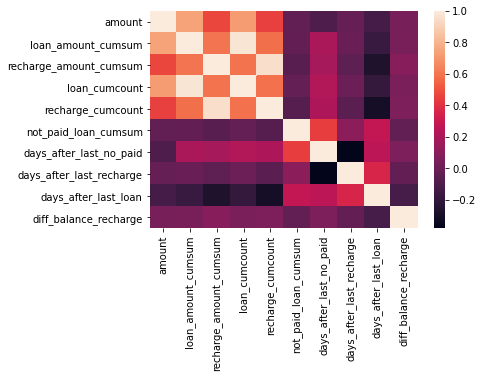

In [30]:
sns.heatmap(df_train[numeric_columns].corr())
plt.show()

In [31]:
Xy = pd.concat((df_train,y_train),axis=1)

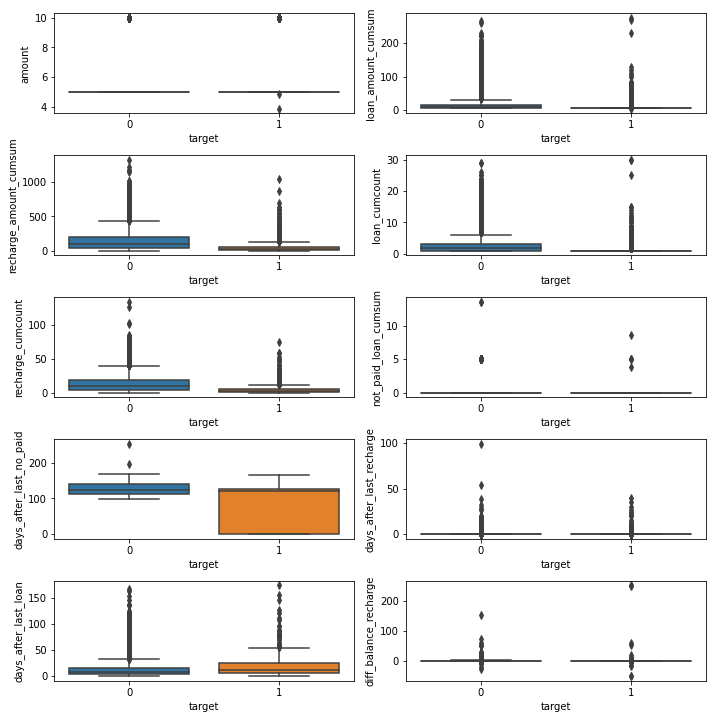

In [32]:
_,ax = plt.subplots(ncols=2,nrows = int(np.ceil(len(numeric_columns)/2)),figsize=(10,10))
ax= ax.flatten()

for i,nc in enumerate(numeric_columns):
    sns.boxplot(data = Xy, x = "target",y=nc, ax=ax[i])
plt.tight_layout()
plt.show()

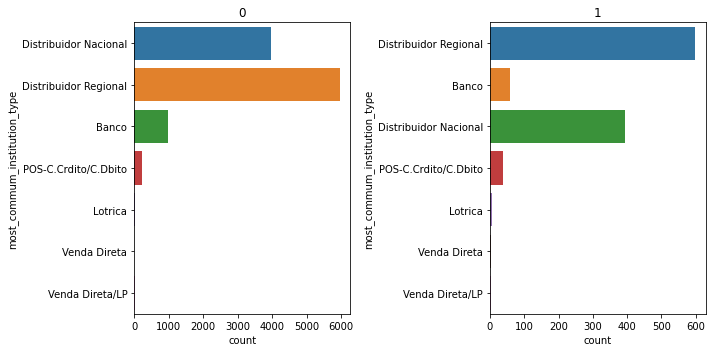

In [33]:
_,ax = plt.subplots(ncols=2,nrows=1,figsize = (10,5))

for t in [0,1]:
    sns.countplot(data = Xy[Xy.target == t],y = "most_commum_institution_type",ax=ax[t],orient="h")
    ax[t].set_title(t)
plt.tight_layout()
plt.show()

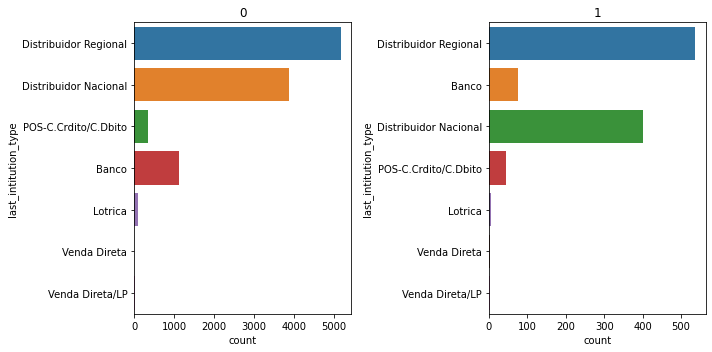

In [34]:
_,ax = plt.subplots(ncols=2,nrows=1,figsize = (10,5))

for t in [0,1]:
    sns.countplot(data = Xy[Xy.target == t],y = "last_intitution_type",ax=ax[t],orient="h")
    ax[t].set_title(t)
plt.tight_layout()
plt.show()

# Modeling

## Simple model

In [35]:
classifier = xgb.XGBClassifier()

In [36]:
#One Hot encoding categorical features
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
ohe.fit(df_train[categorical_columns])

df_train_ = pd.concat((df_train.drop(columns = categorical_columns).reset_index(drop=True),
                       pd.DataFrame(ohe.transform(df_train[categorical_columns]),columns=ohe.get_feature_names_out())),
                axis=1)
df_test_ = pd.concat((df_test.drop(columns = categorical_columns).reset_index(drop=True),
                       pd.DataFrame(ohe.transform(df_test[categorical_columns]),columns=ohe.get_feature_names_out())),
                axis=1)

In [37]:
classifier = classifier.fit(df_train_,y_train)

In [38]:
def metrics(y_true,y_pred):
    print("Recall[%]:",round(100*recall_score(y_true=y_true,y_pred=y_pred),2))
    print("Precision[%]:",round(100*precision_score(y_true=y_true,y_pred=y_pred),2))
    print("AUC[%]:",round(100*roc_auc_score(y_true=y_true,y_score=y_pred),2))
    print("F1-Score[%]:",round(100*f1_score(y_true=y_true,y_pred=y_pred),2))
    print("Balanced Accuracy[%]:",round(100*balanced_accuracy_score(y_true=y_true,y_pred=y_pred),2))
    
    return confusion_matrix(y_true=y_true,y_pred=y_pred)
    
metrics(y_train,classifier.predict(df_train_))

Recall[%]: 46.93
Precision[%]: 76.32
AUC[%]: 72.38
F1-Score[%]: 58.12
Balanced Accuracy[%]: 72.38


array([[11297,   251],
       [  915,   809]], dtype=int64)

In [39]:
print("------------------------------------")
print(metrics(y_test,classifier.predict(df_test_)))
print("------------------------------------")

------------------------------------
Recall[%]: 33.73
Precision[%]: 63.34
AUC[%]: 65.38
F1-Score[%]: 44.02
Balanced Accuracy[%]: 65.38
[[4789  147]
 [ 499  254]]
------------------------------------


First try we had not so good outcome. Let's try oversampling<br>
In order to use the technique, we must input the missing data

## Oversampling

In [40]:
smote = SMOTE(random_state=28)
iter_input = IterativeImputer(random_state=28)

In [41]:
iter_input.fit(df_train_)
df_train_inputer = pd.DataFrame.from_records(iter_input.transform(df_train_),columns=df_train_.columns)

C:\Users\ohbto\AppData\Roaming\Python\Python37\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [42]:
df_train_inputer_smote,y_train_smote = smote.fit_resample(df_train_inputer,y_train)

In [43]:
classifier2 = xgb.XGBClassifier()
classifier2 = classifier2.fit(df_train_inputer_smote,y_train_smote)
metrics(y_train_smote,classifier2.predict(df_train_inputer_smote))

Recall[%]: 94.01
Precision[%]: 91.43
AUC[%]: 92.6
F1-Score[%]: 92.7
Balanced Accuracy[%]: 92.6


array([[10530,  1018],
       [  692, 10856]], dtype=int64)

In [44]:
print("------------------------------------")
print(metrics(y_test,classifier2.predict(iter_input.transform(df_test_))))
print("------------------------------------")

------------------------------------
Recall[%]: 56.84
Precision[%]: 43.28
AUC[%]: 72.74
F1-Score[%]: 49.14
Balanced Accuracy[%]: 72.74
[[4375  561]
 [ 325  428]]
------------------------------------


### Different techniques with oversampled data

In [45]:
for m in [GradientBoostingClassifier(),RandomForestClassifier(),AdaBoostClassifier(),GaussianNB()]:
    m = m.fit(df_train_inputer_smote,y_train_smote)
    print("------------------------------------")
    print(m)
    print(metrics(y_test,m.predict(iter_input.transform(df_test_))))
    print("------------------------------------")

C:\Users\ohbto\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


------------------------------------
GradientBoostingClassifier()


C:\Users\ohbto\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\ohbto\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Recall[%]: 63.75
Precision[%]: 39.57
AUC[%]: 74.45
F1-Score[%]: 48.83
Balanced Accuracy[%]: 74.45
[[4203  733]
 [ 273  480]]
------------------------------------
------------------------------------
RandomForestClassifier()


C:\Users\ohbto\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Recall[%]: 50.46
Precision[%]: 44.5
AUC[%]: 70.43
F1-Score[%]: 47.29
Balanced Accuracy[%]: 70.43
[[4462  474]
 [ 373  380]]
------------------------------------


C:\Users\ohbto\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


------------------------------------
AdaBoostClassifier()


C:\Users\ohbto\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\ohbto\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Recall[%]: 66.67
Precision[%]: 37.55
AUC[%]: 74.88
F1-Score[%]: 48.04
Balanced Accuracy[%]: 74.88
[[4101  835]
 [ 251  502]]
------------------------------------
------------------------------------
GaussianNB()
Recall[%]: 55.11
Precision[%]: 33.41
AUC[%]: 69.18
F1-Score[%]: 41.6
Balanced Accuracy[%]: 69.18
[[4109  827]
 [ 338  415]]
------------------------------------


C:\Users\ohbto\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  "X does not have valid feature names, but"


The other techniques had no much better outcomes. Let's continue with xgboost


# Tunning

Let's take the xgboost technique and tune it's hyperparameters

In [134]:
param_grid = {"alpha":[0,0.005,0.05,0.5,1,2],
              "lambda":[1,1.5,2,3,5],
              "learning_rate":[0.3,0.5,1,0.005,0.05]}

gscv = GridSearchCV(xgb.XGBClassifier(),
                     param_grid = param_grid,
                     cv = 8,
                    verbose=10)

gscv = gscv.fit(df_train_inputer_smote,y_train_smote)


Fitting 8 folds for each of 150 candidates, totalling 1200 fits
[CV 1/8; 1/150] START alpha=0, lambda=1, learning_rate=0.3......................
[CV 1/8; 1/150] END alpha=0, lambda=1, learning_rate=0.3;, score=0.752 total time=   2.0s
[CV 2/8; 1/150] START alpha=0, lambda=1, learning_rate=0.3......................
[CV 2/8; 1/150] END alpha=0, lambda=1, learning_rate=0.3;, score=0.884 total time=   2.1s
[CV 3/8; 1/150] START alpha=0, lambda=1, learning_rate=0.3......................
[CV 3/8; 1/150] END alpha=0, lambda=1, learning_rate=0.3;, score=0.918 total time=   2.0s
[CV 4/8; 1/150] START alpha=0, lambda=1, learning_rate=0.3......................
[CV 4/8; 1/150] END alpha=0, lambda=1, learning_rate=0.3;, score=0.911 total time=   1.9s
[CV 5/8; 1/150] START alpha=0, lambda=1, learning_rate=0.3......................
[CV 5/8; 1/150] END alpha=0, lambda=1, learning_rate=0.3;, score=0.915 total time=   2.0s
[CV 6/8; 1/150] START alpha=0, lambda=1, learning_rate=0.3......................


[CV 8/8; 6/150] END alpha=0, lambda=1.5, learning_rate=0.3;, score=0.915 total time=   0.9s
[CV 1/8; 7/150] START alpha=0, lambda=1.5, learning_rate=0.5....................
[CV 1/8; 7/150] END alpha=0, lambda=1.5, learning_rate=0.5;, score=0.747 total time=   0.9s
[CV 2/8; 7/150] START alpha=0, lambda=1.5, learning_rate=0.5....................
[CV 2/8; 7/150] END alpha=0, lambda=1.5, learning_rate=0.5;, score=0.891 total time=   0.9s
[CV 3/8; 7/150] START alpha=0, lambda=1.5, learning_rate=0.5....................
[CV 3/8; 7/150] END alpha=0, lambda=1.5, learning_rate=0.5;, score=0.921 total time=   0.9s
[CV 4/8; 7/150] START alpha=0, lambda=1.5, learning_rate=0.5....................
[CV 4/8; 7/150] END alpha=0, lambda=1.5, learning_rate=0.5;, score=0.918 total time=   0.9s
[CV 5/8; 7/150] START alpha=0, lambda=1.5, learning_rate=0.5....................
[CV 5/8; 7/150] END alpha=0, lambda=1.5, learning_rate=0.5;, score=0.914 total time=   0.9s
[CV 6/8; 7/150] START alpha=0, lambda=1.5, 

[CV 8/8; 12/150] END alpha=0, lambda=2, learning_rate=0.5;, score=0.913 total time=   0.9s
[CV 1/8; 13/150] START alpha=0, lambda=2, learning_rate=1.......................
[CV 1/8; 13/150] END alpha=0, lambda=2, learning_rate=1;, score=0.754 total time=   0.9s
[CV 2/8; 13/150] START alpha=0, lambda=2, learning_rate=1.......................
[CV 2/8; 13/150] END alpha=0, lambda=2, learning_rate=1;, score=0.886 total time=   0.9s
[CV 3/8; 13/150] START alpha=0, lambda=2, learning_rate=1.......................
[CV 3/8; 13/150] END alpha=0, lambda=2, learning_rate=1;, score=0.913 total time=   0.9s
[CV 4/8; 13/150] START alpha=0, lambda=2, learning_rate=1.......................
[CV 4/8; 13/150] END alpha=0, lambda=2, learning_rate=1;, score=0.914 total time=   0.9s
[CV 5/8; 13/150] START alpha=0, lambda=2, learning_rate=1.......................
[CV 5/8; 13/150] END alpha=0, lambda=2, learning_rate=1;, score=0.911 total time=   0.9s
[CV 6/8; 13/150] START alpha=0, lambda=2, learning_rate=1..

[CV 8/8; 18/150] END alpha=0, lambda=3, learning_rate=1;, score=0.912 total time=   0.9s
[CV 1/8; 19/150] START alpha=0, lambda=3, learning_rate=0.005...................
[CV 1/8; 19/150] END alpha=0, lambda=3, learning_rate=0.005;, score=0.750 total time=   0.9s
[CV 2/8; 19/150] START alpha=0, lambda=3, learning_rate=0.005...................
[CV 2/8; 19/150] END alpha=0, lambda=3, learning_rate=0.005;, score=0.827 total time=   0.9s
[CV 3/8; 19/150] START alpha=0, lambda=3, learning_rate=0.005...................
[CV 3/8; 19/150] END alpha=0, lambda=3, learning_rate=0.005;, score=0.858 total time=   0.9s
[CV 4/8; 19/150] START alpha=0, lambda=3, learning_rate=0.005...................
[CV 4/8; 19/150] END alpha=0, lambda=3, learning_rate=0.005;, score=0.835 total time=   0.9s
[CV 5/8; 19/150] START alpha=0, lambda=3, learning_rate=0.005...................
[CV 5/8; 19/150] END alpha=0, lambda=3, learning_rate=0.005;, score=0.846 total time=   0.9s
[CV 6/8; 19/150] START alpha=0, lambda=3,

[CV 8/8; 24/150] END alpha=0, lambda=5, learning_rate=0.005;, score=0.840 total time=   0.9s
[CV 1/8; 25/150] START alpha=0, lambda=5, learning_rate=0.05....................
[CV 1/8; 25/150] END alpha=0, lambda=5, learning_rate=0.05;, score=0.739 total time=   0.9s
[CV 2/8; 25/150] START alpha=0, lambda=5, learning_rate=0.05....................
[CV 2/8; 25/150] END alpha=0, lambda=5, learning_rate=0.05;, score=0.857 total time=   0.9s
[CV 3/8; 25/150] START alpha=0, lambda=5, learning_rate=0.05....................
[CV 3/8; 25/150] END alpha=0, lambda=5, learning_rate=0.05;, score=0.890 total time=   0.9s
[CV 4/8; 25/150] START alpha=0, lambda=5, learning_rate=0.05....................
[CV 4/8; 25/150] END alpha=0, lambda=5, learning_rate=0.05;, score=0.877 total time=   0.9s
[CV 5/8; 25/150] START alpha=0, lambda=5, learning_rate=0.05....................
[CV 5/8; 25/150] END alpha=0, lambda=5, learning_rate=0.05;, score=0.887 total time=   0.9s
[CV 6/8; 25/150] START alpha=0, lambda=5, 

[CV 7/8; 30/150] END alpha=0.005, lambda=1, learning_rate=0.05;, score=0.880 total time=   0.9s
[CV 8/8; 30/150] START alpha=0.005, lambda=1, learning_rate=0.05................
[CV 8/8; 30/150] END alpha=0.005, lambda=1, learning_rate=0.05;, score=0.880 total time=   0.9s
[CV 1/8; 31/150] START alpha=0.005, lambda=1.5, learning_rate=0.3...............
[CV 1/8; 31/150] END alpha=0.005, lambda=1.5, learning_rate=0.3;, score=0.750 total time=   0.9s
[CV 2/8; 31/150] START alpha=0.005, lambda=1.5, learning_rate=0.3...............
[CV 2/8; 31/150] END alpha=0.005, lambda=1.5, learning_rate=0.3;, score=0.882 total time=   0.9s
[CV 3/8; 31/150] START alpha=0.005, lambda=1.5, learning_rate=0.3...............
[CV 3/8; 31/150] END alpha=0.005, lambda=1.5, learning_rate=0.3;, score=0.916 total time=   0.9s
[CV 4/8; 31/150] START alpha=0.005, lambda=1.5, learning_rate=0.3...............
[CV 4/8; 31/150] END alpha=0.005, lambda=1.5, learning_rate=0.3;, score=0.911 total time=   0.9s
[CV 5/8; 31/150

[CV 6/8; 36/150] END alpha=0.005, lambda=2, learning_rate=0.3;, score=0.920 total time=   0.9s
[CV 7/8; 36/150] START alpha=0.005, lambda=2, learning_rate=0.3.................
[CV 7/8; 36/150] END alpha=0.005, lambda=2, learning_rate=0.3;, score=0.911 total time=   0.9s
[CV 8/8; 36/150] START alpha=0.005, lambda=2, learning_rate=0.3.................
[CV 8/8; 36/150] END alpha=0.005, lambda=2, learning_rate=0.3;, score=0.918 total time=   0.9s
[CV 1/8; 37/150] START alpha=0.005, lambda=2, learning_rate=0.5.................
[CV 1/8; 37/150] END alpha=0.005, lambda=2, learning_rate=0.5;, score=0.754 total time=   0.9s
[CV 2/8; 37/150] START alpha=0.005, lambda=2, learning_rate=0.5.................
[CV 2/8; 37/150] END alpha=0.005, lambda=2, learning_rate=0.5;, score=0.885 total time=   0.9s
[CV 3/8; 37/150] START alpha=0.005, lambda=2, learning_rate=0.5.................
[CV 3/8; 37/150] END alpha=0.005, lambda=2, learning_rate=0.5;, score=0.924 total time=   0.9s
[CV 4/8; 37/150] START al

[CV 5/8; 42/150] END alpha=0.005, lambda=3, learning_rate=0.5;, score=0.921 total time=   1.1s
[CV 6/8; 42/150] START alpha=0.005, lambda=3, learning_rate=0.5.................
[CV 6/8; 42/150] END alpha=0.005, lambda=3, learning_rate=0.5;, score=0.923 total time=   1.0s
[CV 7/8; 42/150] START alpha=0.005, lambda=3, learning_rate=0.5.................
[CV 7/8; 42/150] END alpha=0.005, lambda=3, learning_rate=0.5;, score=0.911 total time=   1.1s
[CV 8/8; 42/150] START alpha=0.005, lambda=3, learning_rate=0.5.................
[CV 8/8; 42/150] END alpha=0.005, lambda=3, learning_rate=0.5;, score=0.914 total time=   1.1s
[CV 1/8; 43/150] START alpha=0.005, lambda=3, learning_rate=1...................
[CV 1/8; 43/150] END alpha=0.005, lambda=3, learning_rate=1;, score=0.755 total time=   0.9s
[CV 2/8; 43/150] START alpha=0.005, lambda=3, learning_rate=1...................
[CV 2/8; 43/150] END alpha=0.005, lambda=3, learning_rate=1;, score=0.881 total time=   1.0s
[CV 3/8; 43/150] START alpha=

[CV 4/8; 48/150] END alpha=0.005, lambda=5, learning_rate=1;, score=0.915 total time=   0.9s
[CV 5/8; 48/150] START alpha=0.005, lambda=5, learning_rate=1...................
[CV 5/8; 48/150] END alpha=0.005, lambda=5, learning_rate=1;, score=0.916 total time=   0.9s
[CV 6/8; 48/150] START alpha=0.005, lambda=5, learning_rate=1...................
[CV 6/8; 48/150] END alpha=0.005, lambda=5, learning_rate=1;, score=0.917 total time=   0.9s
[CV 7/8; 48/150] START alpha=0.005, lambda=5, learning_rate=1...................
[CV 7/8; 48/150] END alpha=0.005, lambda=5, learning_rate=1;, score=0.915 total time=   0.9s
[CV 8/8; 48/150] START alpha=0.005, lambda=5, learning_rate=1...................
[CV 8/8; 48/150] END alpha=0.005, lambda=5, learning_rate=1;, score=0.916 total time=   0.9s
[CV 1/8; 49/150] START alpha=0.005, lambda=5, learning_rate=0.005...............
[CV 1/8; 49/150] END alpha=0.005, lambda=5, learning_rate=0.005;, score=0.749 total time=   0.9s
[CV 2/8; 49/150] START alpha=0.00

[CV 3/8; 54/150] END alpha=0.05, lambda=1, learning_rate=0.005;, score=0.857 total time=   1.9s
[CV 4/8; 54/150] START alpha=0.05, lambda=1, learning_rate=0.005................
[CV 4/8; 54/150] END alpha=0.05, lambda=1, learning_rate=0.005;, score=0.838 total time=   1.4s
[CV 5/8; 54/150] START alpha=0.05, lambda=1, learning_rate=0.005................
[CV 5/8; 54/150] END alpha=0.05, lambda=1, learning_rate=0.005;, score=0.848 total time=   1.4s
[CV 6/8; 54/150] START alpha=0.05, lambda=1, learning_rate=0.005................
[CV 6/8; 54/150] END alpha=0.05, lambda=1, learning_rate=0.005;, score=0.855 total time=   1.4s
[CV 7/8; 54/150] START alpha=0.05, lambda=1, learning_rate=0.005................
[CV 7/8; 54/150] END alpha=0.05, lambda=1, learning_rate=0.005;, score=0.842 total time=   1.2s
[CV 8/8; 54/150] START alpha=0.05, lambda=1, learning_rate=0.005................
[CV 8/8; 54/150] END alpha=0.05, lambda=1, learning_rate=0.005;, score=0.843 total time=   1.3s
[CV 1/8; 55/150] ST

[CV 2/8; 60/150] END alpha=0.05, lambda=1.5, learning_rate=0.05;, score=0.858 total time=   1.2s
[CV 3/8; 60/150] START alpha=0.05, lambda=1.5, learning_rate=0.05...............
[CV 3/8; 60/150] END alpha=0.05, lambda=1.5, learning_rate=0.05;, score=0.892 total time=   1.2s
[CV 4/8; 60/150] START alpha=0.05, lambda=1.5, learning_rate=0.05...............
[CV 4/8; 60/150] END alpha=0.05, lambda=1.5, learning_rate=0.05;, score=0.878 total time=   1.2s
[CV 5/8; 60/150] START alpha=0.05, lambda=1.5, learning_rate=0.05...............
[CV 5/8; 60/150] END alpha=0.05, lambda=1.5, learning_rate=0.05;, score=0.887 total time=   1.2s
[CV 6/8; 60/150] START alpha=0.05, lambda=1.5, learning_rate=0.05...............
[CV 6/8; 60/150] END alpha=0.05, lambda=1.5, learning_rate=0.05;, score=0.894 total time=   1.2s
[CV 7/8; 60/150] START alpha=0.05, lambda=1.5, learning_rate=0.05...............
[CV 7/8; 60/150] END alpha=0.05, lambda=1.5, learning_rate=0.05;, score=0.880 total time=   1.2s
[CV 8/8; 60/1

[CV 1/8; 66/150] END alpha=0.05, lambda=3, learning_rate=0.3;, score=0.748 total time=   1.1s
[CV 2/8; 66/150] START alpha=0.05, lambda=3, learning_rate=0.3..................
[CV 2/8; 66/150] END alpha=0.05, lambda=3, learning_rate=0.3;, score=0.892 total time=   1.1s
[CV 3/8; 66/150] START alpha=0.05, lambda=3, learning_rate=0.3..................
[CV 3/8; 66/150] END alpha=0.05, lambda=3, learning_rate=0.3;, score=0.917 total time=   1.1s
[CV 4/8; 66/150] START alpha=0.05, lambda=3, learning_rate=0.3..................
[CV 4/8; 66/150] END alpha=0.05, lambda=3, learning_rate=0.3;, score=0.913 total time=   1.2s
[CV 5/8; 66/150] START alpha=0.05, lambda=3, learning_rate=0.3..................
[CV 5/8; 66/150] END alpha=0.05, lambda=3, learning_rate=0.3;, score=0.915 total time=   1.2s
[CV 6/8; 66/150] START alpha=0.05, lambda=3, learning_rate=0.3..................
[CV 6/8; 66/150] END alpha=0.05, lambda=3, learning_rate=0.3;, score=0.926 total time=   1.2s
[CV 7/8; 66/150] START alpha=0.

[CV 8/8; 71/150] END alpha=0.05, lambda=5, learning_rate=0.3;, score=0.913 total time=   1.2s
[CV 1/8; 72/150] START alpha=0.05, lambda=5, learning_rate=0.5..................
[CV 1/8; 72/150] END alpha=0.05, lambda=5, learning_rate=0.5;, score=0.746 total time=   1.2s
[CV 2/8; 72/150] START alpha=0.05, lambda=5, learning_rate=0.5..................
[CV 2/8; 72/150] END alpha=0.05, lambda=5, learning_rate=0.5;, score=0.890 total time=   1.1s
[CV 3/8; 72/150] START alpha=0.05, lambda=5, learning_rate=0.5..................
[CV 3/8; 72/150] END alpha=0.05, lambda=5, learning_rate=0.5;, score=0.918 total time=   1.1s
[CV 4/8; 72/150] START alpha=0.05, lambda=5, learning_rate=0.5..................
[CV 4/8; 72/150] END alpha=0.05, lambda=5, learning_rate=0.5;, score=0.916 total time=   1.1s
[CV 5/8; 72/150] START alpha=0.05, lambda=5, learning_rate=0.5..................
[CV 5/8; 72/150] END alpha=0.05, lambda=5, learning_rate=0.5;, score=0.922 total time=   1.1s
[CV 6/8; 72/150] START alpha=0.

[CV 7/8; 77/150] END alpha=0.5, lambda=1, learning_rate=0.5;, score=0.911 total time=   1.1s
[CV 8/8; 77/150] START alpha=0.5, lambda=1, learning_rate=0.5...................
[CV 8/8; 77/150] END alpha=0.5, lambda=1, learning_rate=0.5;, score=0.918 total time=   1.2s
[CV 1/8; 78/150] START alpha=0.5, lambda=1, learning_rate=1.....................
[CV 1/8; 78/150] END alpha=0.5, lambda=1, learning_rate=1;, score=0.747 total time=   1.1s
[CV 2/8; 78/150] START alpha=0.5, lambda=1, learning_rate=1.....................
[CV 2/8; 78/150] END alpha=0.5, lambda=1, learning_rate=1;, score=0.886 total time=   1.2s
[CV 3/8; 78/150] START alpha=0.5, lambda=1, learning_rate=1.....................
[CV 3/8; 78/150] END alpha=0.5, lambda=1, learning_rate=1;, score=0.911 total time=   1.2s
[CV 4/8; 78/150] START alpha=0.5, lambda=1, learning_rate=1.....................
[CV 4/8; 78/150] END alpha=0.5, lambda=1, learning_rate=1;, score=0.907 total time=   1.2s
[CV 5/8; 78/150] START alpha=0.5, lambda=1, l

[CV 6/8; 83/150] END alpha=0.5, lambda=1.5, learning_rate=1;, score=0.919 total time=   1.1s
[CV 7/8; 83/150] START alpha=0.5, lambda=1.5, learning_rate=1...................
[CV 7/8; 83/150] END alpha=0.5, lambda=1.5, learning_rate=1;, score=0.908 total time=   1.2s
[CV 8/8; 83/150] START alpha=0.5, lambda=1.5, learning_rate=1...................
[CV 8/8; 83/150] END alpha=0.5, lambda=1.5, learning_rate=1;, score=0.915 total time=   1.1s
[CV 1/8; 84/150] START alpha=0.5, lambda=1.5, learning_rate=0.005...............
[CV 1/8; 84/150] END alpha=0.5, lambda=1.5, learning_rate=0.005;, score=0.749 total time=   1.2s
[CV 2/8; 84/150] START alpha=0.5, lambda=1.5, learning_rate=0.005...............
[CV 2/8; 84/150] END alpha=0.5, lambda=1.5, learning_rate=0.005;, score=0.828 total time=   1.2s
[CV 3/8; 84/150] START alpha=0.5, lambda=1.5, learning_rate=0.005...............
[CV 3/8; 84/150] END alpha=0.5, lambda=1.5, learning_rate=0.005;, score=0.856 total time=   1.2s
[CV 4/8; 84/150] START al

[CV 5/8; 89/150] END alpha=0.5, lambda=2, learning_rate=0.005;, score=0.846 total time=   1.2s
[CV 6/8; 89/150] START alpha=0.5, lambda=2, learning_rate=0.005.................
[CV 6/8; 89/150] END alpha=0.5, lambda=2, learning_rate=0.005;, score=0.854 total time=   1.2s
[CV 7/8; 89/150] START alpha=0.5, lambda=2, learning_rate=0.005.................
[CV 7/8; 89/150] END alpha=0.5, lambda=2, learning_rate=0.005;, score=0.841 total time=   1.2s
[CV 8/8; 89/150] START alpha=0.5, lambda=2, learning_rate=0.005.................
[CV 8/8; 89/150] END alpha=0.5, lambda=2, learning_rate=0.005;, score=0.842 total time=   1.2s
[CV 1/8; 90/150] START alpha=0.5, lambda=2, learning_rate=0.05..................
[CV 1/8; 90/150] END alpha=0.5, lambda=2, learning_rate=0.05;, score=0.740 total time=   1.2s
[CV 2/8; 90/150] START alpha=0.5, lambda=2, learning_rate=0.05..................
[CV 2/8; 90/150] END alpha=0.5, lambda=2, learning_rate=0.05;, score=0.858 total time=   1.2s
[CV 3/8; 90/150] START alph

[CV 4/8; 95/150] END alpha=0.5, lambda=3, learning_rate=0.05;, score=0.878 total time=   1.3s
[CV 5/8; 95/150] START alpha=0.5, lambda=3, learning_rate=0.05..................
[CV 5/8; 95/150] END alpha=0.5, lambda=3, learning_rate=0.05;, score=0.890 total time=   1.3s
[CV 6/8; 95/150] START alpha=0.5, lambda=3, learning_rate=0.05..................
[CV 6/8; 95/150] END alpha=0.5, lambda=3, learning_rate=0.05;, score=0.894 total time=   1.3s
[CV 7/8; 95/150] START alpha=0.5, lambda=3, learning_rate=0.05..................
[CV 7/8; 95/150] END alpha=0.5, lambda=3, learning_rate=0.05;, score=0.879 total time=   1.2s
[CV 8/8; 95/150] START alpha=0.5, lambda=3, learning_rate=0.05..................
[CV 8/8; 95/150] END alpha=0.5, lambda=3, learning_rate=0.05;, score=0.881 total time=   1.2s
[CV 1/8; 96/150] START alpha=0.5, lambda=5, learning_rate=0.3...................
[CV 1/8; 96/150] END alpha=0.5, lambda=5, learning_rate=0.3;, score=0.746 total time=   1.2s
[CV 2/8; 96/150] START alpha=0.5

[CV 3/8; 101/150] END alpha=1, lambda=1, learning_rate=0.3;, score=0.920 total time=   1.2s
[CV 4/8; 101/150] START alpha=1, lambda=1, learning_rate=0.3....................
[CV 4/8; 101/150] END alpha=1, lambda=1, learning_rate=0.3;, score=0.914 total time=   1.2s
[CV 5/8; 101/150] START alpha=1, lambda=1, learning_rate=0.3....................
[CV 5/8; 101/150] END alpha=1, lambda=1, learning_rate=0.3;, score=0.916 total time=   1.2s
[CV 6/8; 101/150] START alpha=1, lambda=1, learning_rate=0.3....................
[CV 6/8; 101/150] END alpha=1, lambda=1, learning_rate=0.3;, score=0.922 total time=   1.3s
[CV 7/8; 101/150] START alpha=1, lambda=1, learning_rate=0.3....................
[CV 7/8; 101/150] END alpha=1, lambda=1, learning_rate=0.3;, score=0.913 total time=   1.2s
[CV 8/8; 101/150] START alpha=1, lambda=1, learning_rate=0.3....................
[CV 8/8; 101/150] END alpha=1, lambda=1, learning_rate=0.3;, score=0.913 total time=   1.2s
[CV 1/8; 102/150] START alpha=1, lambda=1, 

[CV 3/8; 107/150] END alpha=1, lambda=1.5, learning_rate=0.5;, score=0.922 total time=   1.2s
[CV 4/8; 107/150] START alpha=1, lambda=1.5, learning_rate=0.5..................
[CV 4/8; 107/150] END alpha=1, lambda=1.5, learning_rate=0.5;, score=0.920 total time=   1.2s
[CV 5/8; 107/150] START alpha=1, lambda=1.5, learning_rate=0.5..................
[CV 5/8; 107/150] END alpha=1, lambda=1.5, learning_rate=0.5;, score=0.923 total time=   1.3s
[CV 6/8; 107/150] START alpha=1, lambda=1.5, learning_rate=0.5..................
[CV 6/8; 107/150] END alpha=1, lambda=1.5, learning_rate=0.5;, score=0.929 total time=   1.2s
[CV 7/8; 107/150] START alpha=1, lambda=1.5, learning_rate=0.5..................
[CV 7/8; 107/150] END alpha=1, lambda=1.5, learning_rate=0.5;, score=0.915 total time=   1.2s
[CV 8/8; 107/150] START alpha=1, lambda=1.5, learning_rate=0.5..................
[CV 8/8; 107/150] END alpha=1, lambda=1.5, learning_rate=0.5;, score=0.920 total time=   1.2s
[CV 1/8; 108/150] START alpha=1

[CV 2/8; 113/150] END alpha=1, lambda=2, learning_rate=1;, score=0.885 total time=   1.2s
[CV 3/8; 113/150] START alpha=1, lambda=2, learning_rate=1......................
[CV 3/8; 113/150] END alpha=1, lambda=2, learning_rate=1;, score=0.910 total time=   1.1s
[CV 4/8; 113/150] START alpha=1, lambda=2, learning_rate=1......................
[CV 4/8; 113/150] END alpha=1, lambda=2, learning_rate=1;, score=0.911 total time=   1.2s
[CV 5/8; 113/150] START alpha=1, lambda=2, learning_rate=1......................
[CV 5/8; 113/150] END alpha=1, lambda=2, learning_rate=1;, score=0.913 total time=   1.2s
[CV 6/8; 113/150] START alpha=1, lambda=2, learning_rate=1......................
[CV 6/8; 113/150] END alpha=1, lambda=2, learning_rate=1;, score=0.921 total time=   1.1s
[CV 7/8; 113/150] START alpha=1, lambda=2, learning_rate=1......................
[CV 7/8; 113/150] END alpha=1, lambda=2, learning_rate=1;, score=0.913 total time=   1.2s
[CV 8/8; 113/150] START alpha=1, lambda=2, learning_rat

[CV 2/8; 119/150] END alpha=1, lambda=3, learning_rate=0.005;, score=0.827 total time=   1.2s
[CV 3/8; 119/150] START alpha=1, lambda=3, learning_rate=0.005..................
[CV 3/8; 119/150] END alpha=1, lambda=3, learning_rate=0.005;, score=0.861 total time=   1.2s
[CV 4/8; 119/150] START alpha=1, lambda=3, learning_rate=0.005..................
[CV 4/8; 119/150] END alpha=1, lambda=3, learning_rate=0.005;, score=0.834 total time=   1.3s
[CV 5/8; 119/150] START alpha=1, lambda=3, learning_rate=0.005..................
[CV 5/8; 119/150] END alpha=1, lambda=3, learning_rate=0.005;, score=0.842 total time=   1.3s
[CV 6/8; 119/150] START alpha=1, lambda=3, learning_rate=0.005..................
[CV 6/8; 119/150] END alpha=1, lambda=3, learning_rate=0.005;, score=0.852 total time=   1.2s
[CV 7/8; 119/150] START alpha=1, lambda=3, learning_rate=0.005..................
[CV 7/8; 119/150] END alpha=1, lambda=3, learning_rate=0.005;, score=0.841 total time=   1.1s
[CV 8/8; 119/150] START alpha=1

[CV 2/8; 125/150] END alpha=1, lambda=5, learning_rate=0.05;, score=0.859 total time=   1.2s
[CV 3/8; 125/150] START alpha=1, lambda=5, learning_rate=0.05...................
[CV 3/8; 125/150] END alpha=1, lambda=5, learning_rate=0.05;, score=0.888 total time=   1.2s
[CV 4/8; 125/150] START alpha=1, lambda=5, learning_rate=0.05...................
[CV 4/8; 125/150] END alpha=1, lambda=5, learning_rate=0.05;, score=0.875 total time=   1.2s
[CV 5/8; 125/150] START alpha=1, lambda=5, learning_rate=0.05...................
[CV 5/8; 125/150] END alpha=1, lambda=5, learning_rate=0.05;, score=0.886 total time=   1.2s
[CV 6/8; 125/150] START alpha=1, lambda=5, learning_rate=0.05...................
[CV 6/8; 125/150] END alpha=1, lambda=5, learning_rate=0.05;, score=0.891 total time=   1.2s
[CV 7/8; 125/150] START alpha=1, lambda=5, learning_rate=0.05...................
[CV 7/8; 125/150] END alpha=1, lambda=5, learning_rate=0.05;, score=0.877 total time=   1.2s
[CV 8/8; 125/150] START alpha=1, lamb

[CV 2/8; 131/150] END alpha=2, lambda=1.5, learning_rate=0.3;, score=0.888 total time=   1.1s
[CV 3/8; 131/150] START alpha=2, lambda=1.5, learning_rate=0.3..................
[CV 3/8; 131/150] END alpha=2, lambda=1.5, learning_rate=0.3;, score=0.918 total time=   1.0s
[CV 4/8; 131/150] START alpha=2, lambda=1.5, learning_rate=0.3..................
[CV 4/8; 131/150] END alpha=2, lambda=1.5, learning_rate=0.3;, score=0.916 total time=   1.0s
[CV 5/8; 131/150] START alpha=2, lambda=1.5, learning_rate=0.3..................
[CV 5/8; 131/150] END alpha=2, lambda=1.5, learning_rate=0.3;, score=0.922 total time=   1.0s
[CV 6/8; 131/150] START alpha=2, lambda=1.5, learning_rate=0.3..................
[CV 6/8; 131/150] END alpha=2, lambda=1.5, learning_rate=0.3;, score=0.927 total time=   1.1s
[CV 7/8; 131/150] START alpha=2, lambda=1.5, learning_rate=0.3..................
[CV 7/8; 131/150] END alpha=2, lambda=1.5, learning_rate=0.3;, score=0.914 total time=   1.1s
[CV 8/8; 131/150] START alpha=2

[CV 1/8; 137/150] END alpha=2, lambda=2, learning_rate=0.5;, score=0.755 total time=   1.3s
[CV 2/8; 137/150] START alpha=2, lambda=2, learning_rate=0.5....................
[CV 2/8; 137/150] END alpha=2, lambda=2, learning_rate=0.5;, score=0.892 total time=   1.3s
[CV 3/8; 137/150] START alpha=2, lambda=2, learning_rate=0.5....................
[CV 3/8; 137/150] END alpha=2, lambda=2, learning_rate=0.5;, score=0.916 total time=   1.3s
[CV 4/8; 137/150] START alpha=2, lambda=2, learning_rate=0.5....................
[CV 4/8; 137/150] END alpha=2, lambda=2, learning_rate=0.5;, score=0.915 total time=   1.3s
[CV 5/8; 137/150] START alpha=2, lambda=2, learning_rate=0.5....................
[CV 5/8; 137/150] END alpha=2, lambda=2, learning_rate=0.5;, score=0.919 total time=   1.2s
[CV 6/8; 137/150] START alpha=2, lambda=2, learning_rate=0.5....................
[CV 6/8; 137/150] END alpha=2, lambda=2, learning_rate=0.5;, score=0.924 total time=   1.2s
[CV 7/8; 137/150] START alpha=2, lambda=2, 

[CV 1/8; 143/150] END alpha=2, lambda=3, learning_rate=1;, score=0.755 total time=   1.2s
[CV 2/8; 143/150] START alpha=2, lambda=3, learning_rate=1......................
[CV 2/8; 143/150] END alpha=2, lambda=3, learning_rate=1;, score=0.887 total time=   1.3s
[CV 3/8; 143/150] START alpha=2, lambda=3, learning_rate=1......................
[CV 3/8; 143/150] END alpha=2, lambda=3, learning_rate=1;, score=0.915 total time=   1.3s
[CV 4/8; 143/150] START alpha=2, lambda=3, learning_rate=1......................
[CV 4/8; 143/150] END alpha=2, lambda=3, learning_rate=1;, score=0.915 total time=   1.3s
[CV 5/8; 143/150] START alpha=2, lambda=3, learning_rate=1......................
[CV 5/8; 143/150] END alpha=2, lambda=3, learning_rate=1;, score=0.919 total time=   1.3s
[CV 6/8; 143/150] START alpha=2, lambda=3, learning_rate=1......................
[CV 6/8; 143/150] END alpha=2, lambda=3, learning_rate=1;, score=0.920 total time=   1.3s
[CV 7/8; 143/150] START alpha=2, lambda=3, learning_rat

[CV 1/8; 149/150] END alpha=2, lambda=5, learning_rate=0.005;, score=0.748 total time=   1.3s
[CV 2/8; 149/150] START alpha=2, lambda=5, learning_rate=0.005..................
[CV 2/8; 149/150] END alpha=2, lambda=5, learning_rate=0.005;, score=0.823 total time=   1.4s
[CV 3/8; 149/150] START alpha=2, lambda=5, learning_rate=0.005..................
[CV 3/8; 149/150] END alpha=2, lambda=5, learning_rate=0.005;, score=0.858 total time=   1.3s
[CV 4/8; 149/150] START alpha=2, lambda=5, learning_rate=0.005..................
[CV 4/8; 149/150] END alpha=2, lambda=5, learning_rate=0.005;, score=0.835 total time=   1.3s
[CV 5/8; 149/150] START alpha=2, lambda=5, learning_rate=0.005..................
[CV 5/8; 149/150] END alpha=2, lambda=5, learning_rate=0.005;, score=0.841 total time=   1.4s
[CV 6/8; 149/150] START alpha=2, lambda=5, learning_rate=0.005..................
[CV 6/8; 149/150] END alpha=2, lambda=5, learning_rate=0.005;, score=0.851 total time=   1.3s
[CV 7/8; 149/150] START alpha=2

In [135]:
classifier3 = gscv.best_estimator_
print("------------------------------------")
print(metrics(y_test,classifier3.predict(iter_input.transform(df_test_))))
print("------------------------------------")

------------------------------------
Recall[%]: 54.32
Precision[%]: 43.93
AUC[%]: 71.87
F1-Score[%]: 48.57
Balanced Accuracy[%]: 71.87
[[4414  522]
 [ 344  409]]
------------------------------------


Even getting a worse score than classifier2, classifier3 passed over a cross-validation score, so it may have a more robust ability to predict. In this case, we will select it